# Imports and configs

In [1]:
!pip install -q scikit-learn==1.5.2 autogluon.tabular==1.3 ray==2.10.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 382.4/382.4 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.7/222.7 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 3.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


In [2]:
from autogluon.tabular import TabularPredictor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import numpy as np
import joblib
import os

warnings.filterwarnings("ignore")

In [3]:
class CFG:
    train_path = "/kaggle/input/playground-series-s5e5/train.csv"
    test_path = "/kaggle/input/playground-series-s5e5/test.csv"
    sample_sub_path = "/kaggle/input/playground-series-s5e5/sample_submission.csv"
    
    target = "Calories"
    n_folds = 5
    seed = 42
    time_limit = 3600 * 10

# Loading data and predefining folds

In [4]:
train = pd.read_csv(CFG.train_path, index_col="id")
train[CFG.target] = np.log1p(train[CFG.target])

test = pd.read_csv(CFG.test_path, index_col="id")

train["Sex"] = train["Sex"].map({"male": 0, "female": 1})
test["Sex"] = test["Sex"].map({"male": 0, "female": 1})

train["is_duplicate"] = train.duplicated(subset=test.columns)
test["is_duplicate"] = test.duplicated(subset=test.columns)

In [5]:
kf = KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True)
split = kf.split(train, train[CFG.target])
for i, (_, val_index) in enumerate(split):
    train.loc[val_index, "fold"] = i

# Fitting the predictor

In [6]:
predictor = TabularPredictor(
    path="/logs",
    problem_type="regression",
    eval_metric="rmse",
    label=CFG.target,
    groups="fold",
    verbosity=2
)

In [7]:
predictor.fit(
    train_data=train,
    time_limit=CFG.time_limit,
    presets="best_quality",
    excluded_model_types=["KNN"]
)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
Memory Avail:       29.96 GB / 31.35 GB (95.6%)
Disk Space Avail:   1784.39 GB / 8062.39 GB (22.1%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect st

(_ray_fit pid=460) [1000]	valid_set's rmse: 0.0627205
(_ray_fit pid=460) [2000]	valid_set's rmse: 0.0610112 [repeated 4x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(_ray_fit pid=461) [3000]	valid_set's rmse: 0.0602769 [repeated 4x across cluster]
(_ray_fit pid=462) [4000]	valid_set's rmse: 0.06036 [repeated 4x across cluster]
(_ray_fit pid=462) [5000]	valid_set's rmse: 0.0602909 [repeated 4x across cluster]
(_ray_fit pid=462) [6000]	valid_set's rmse: 0.0602603 [repeated 4x across cluster]
(_ray_fit pid=462) [7000]	valid_set's rmse: 0.0602558 [repeated 4x across cluster]
(_ray_fit pid=462) [8000]	valid_set's rmse: 0.0602652 [repeated 4x across cluster]
(_ray_fit pid=461) [8000]	valid_set's rmse: 0.060023 [repeated 2x across cluster]
(_ray_fit pid=460) [9000]	valid_set's rmse: 0.0604256
(_ray_fit pid=461) [9000]	valid_set'

(_dystack pid=169) 	-0.06	 = Validation score   (-root_mean_squared_error)
(_dystack pid=169) 	867.8s	 = Training   runtime
(_dystack pid=169) 	817.01s	 = Validation runtime
(_dystack pid=169) Fitting model: LightGBM_BAG_L1 ... Training model for up to 4985.27s of the 7984.61s of remaining time.
(_dystack pid=169) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.83%)


(_ray_fit pid=712) [1000]	valid_set's rmse: 0.0601695
(_ray_fit pid=712) [2000]	valid_set's rmse: 0.0600881 [repeated 4x across cluster]
(_ray_fit pid=713) [2000]	valid_set's rmse: 0.060467 [repeated 3x across cluster]
(_ray_fit pid=713) [3000]	valid_set's rmse: 0.0604973
(_ray_fit pid=826) [1000]	valid_set's rmse: 0.0597835


(_dystack pid=169) 	-0.0601	 = Validation score   (-root_mean_squared_error)
(_dystack pid=169) 	136.36s	 = Training   runtime
(_dystack pid=169) 	118.74s	 = Validation runtime
(_dystack pid=169) Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 4831.28s of the 7830.62s of remaining time.
(_dystack pid=169) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=169) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=1.60%)
(_dystack pid=169) 	-0.0632	 = Validation score   (-root_mean_squared_error)
(_dystack pid=169) 	974.34s	 = Training   runtime
(_dystack pid=169) 	48.12s	 = Validation runtime
(_dystack pid=169) Fitting model: CatBoost_BAG_L1 ... Training model for up to 3849.46s of the 6848.80s of remaining time.
(_dystack pid=169) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=2.15%)
(_dystack 

(_ray_fit pid=2716) [1000]	valid_set's rmse: 0.0606115


(_dystack pid=169) 	-0.06	 = Validation score   (-root_mean_squared_error)
(_dystack pid=169) 	99.1s	 = Training   runtime
(_dystack pid=169) 	78.75s	 = Validation runtime
(_dystack pid=169) Fitting model: CatBoost_r177_BAG_L1 ... Training model for up to 1090.41s of the 4089.75s of remaining time.
(_dystack pid=169) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=2.14%)
(_dystack pid=169) 	-0.0595	 = Validation score   (-root_mean_squared_error)
(_dystack pid=169) 	292.63s	 = Training   runtime
(_dystack pid=169) 	0.87s	 = Validation runtime
(_dystack pid=169) Fitting model: NeuralNetTorch_r79_BAG_L1 ... Training model for up to 794.13s of the 3793.47s of remaining time.
(_dystack pid=169) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.79%)
(_ray_fit pid=3246) 	Ran out of time, stopping training early. (Stopping on epoch 16)
(_r

(_ray_fit pid=3504) [1000]	valid_set's rmse: 0.0594541


(_ray_fit pid=3504) 	Ran out of time, early stopping on iteration 1456. Best iteration is:
(_ray_fit pid=3504) 	[1452]	valid_set's rmse: 0.0592004


(_ray_fit pid=3619) [1000]	valid_set's rmse: 0.0599836 [repeated 4x across cluster]
(_ray_fit pid=3619) [2000]	valid_set's rmse: 0.0594878


(_ray_fit pid=3619) 	Ran out of time, early stopping on iteration 2873. Best iteration is: [repeated 4x across cluster]
(_ray_fit pid=3619) 	[2873]	valid_set's rmse: 0.0593922 [repeated 4x across cluster]
(_dystack pid=169) 	-0.06	 = Validation score   (-root_mean_squared_error)
(_dystack pid=169) 	211.63s	 = Training   runtime
(_dystack pid=169) 	197.78s	 = Validation runtime
(_dystack pid=169) Fitting model: WeightedEnsemble_L2 ... Training model for up to 599.42s of the 2955.35s of remaining time.
(_dystack pid=169) 	Ensemble Weights: {'CatBoost_BAG_L1': 0.333, 'LightGBMXT_BAG_L1': 0.133, 'LightGBMLarge_BAG_L1': 0.133, 'RandomForestMSE_BAG_L1': 0.067, 'ExtraTreesMSE_BAG_L1': 0.067, 'NeuralNetFastAI_BAG_L1': 0.067, 'XGBoost_BAG_L1': 0.067, 'CatBoost_r177_BAG_L1': 0.067, 'LightGBM_r131_BAG_L1': 0.067}
(_dystack pid=169) 	-0.0591	 = Validation score   (-root_mean_squared_error)
(_dystack pid=169) 	1.15s	 = Training   runtime
(_dystack pid=169) 	0.02s	 = Validation runtime
(_dystack pid

(_ray_fit pid=3754) [1000]	valid_set's rmse: 0.0607861
(_ray_fit pid=3753) [1000]	valid_set's rmse: 0.0596341 [repeated 3x across cluster]
(_ray_fit pid=3754) [2000]	valid_set's rmse: 0.0606743
(_ray_fit pid=3756) [2000]	valid_set's rmse: 0.0602524
(_ray_fit pid=3753) [2000]	valid_set's rmse: 0.0595844 [repeated 2x across cluster]
(_ray_fit pid=3756) [3000]	valid_set's rmse: 0.0601957
(_ray_fit pid=3755) [3000]	valid_set's rmse: 0.0600762
(_ray_fit pid=3756) [4000]	valid_set's rmse: 0.0601643
(_ray_fit pid=3755) [4000]	valid_set's rmse: 0.0600389
(_ray_fit pid=3868) [1000]	valid_set's rmse: 0.0598637
(_ray_fit pid=3756) [5000]	valid_set's rmse: 0.0601443
(_ray_fit pid=3756) [6000]	valid_set's rmse: 0.0601305
(_ray_fit pid=3756) [7000]	valid_set's rmse: 0.0601478


(_dystack pid=169) 	-0.0601	 = Validation score   (-root_mean_squared_error)
(_dystack pid=169) 	447.04s	 = Training   runtime
(_dystack pid=169) 	268.01s	 = Validation runtime
(_dystack pid=169) Fitting model: LightGBM_BAG_L2 ... Training model for up to 2405.27s of the 2405.16s of remaining time.
(_dystack pid=169) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=1.48%)
(_dystack pid=169) 	-0.0595	 = Validation score   (-root_mean_squared_error)
(_dystack pid=169) 	44.97s	 = Training   runtime
(_dystack pid=169) 	6.24s	 = Validation runtime
(_dystack pid=169) Fitting model: RandomForestMSE_BAG_L2 ... Training model for up to 2355.43s of the 2355.31s of remaining time.
(_dystack pid=169) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=169) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=1.70%)
(_ray_fit pi

In [8]:
predictor.leaderboard(silent=True).style.background_gradient(subset=["score_val"], cmap="RdYlGn")

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-0.059001,root_mean_squared_error,3813.257178,24269.902183,0.016250,3.211636,3,True,33
1,WeightedEnsemble_L2,-0.059035,root_mean_squared_error,1800.797522,6767.057580,0.031339,2.268406,2,True,23
2,LightGBM_BAG_L2,-0.059381,root_mean_squared_error,3769.070115,17299.187510,7.765910,64.011480,2,True,25
3,ExtraTreesMSE_BAG_L2,-0.059387,root_mean_squared_error,3785.670040,18183.799350,24.365835,948.623320,2,True,28
4,CatBoost_BAG_L1,-0.059409,root_mean_squared_error,1.282821,507.707503,1.282821,507.707503,1,True,4
5,XGBoost_BAG_L2,-0.059430,root_mean_squared_error,3766.205199,17319.104145,4.900994,83.928114,2,True,30
6,CatBoost_r177_BAG_L1,-0.059479,root_mean_squared_error,1.246871,445.669957,1.246871,445.669957,1,True,10
7,CatBoost_r137_BAG_L1,-0.059605,root_mean_squared_error,3.293549,655.336365,3.293549,655.336365,1,True,19
8,CatBoost_r13_BAG_L1,-0.059616,root_mean_squared_error,1.642847,339.043901,1.642847,339.043901,1,True,21
9,CatBoost_r9_BAG_L1,-0.059625,root_mean_squared_error,12.236238,787.764028,12.236238,787.764028,1,True,14


# Visualizing the ensemble weights

In [9]:
def get_ensemble_weights(predictor):
    info = predictor.info()
    ensemble_weights = {}
    for model_name, values in info["model_info"].items():
        if "Ensemble" in model_name:
            children_info = values["children_info"]
            ensemble_weights[model_name] = values["children_info"][list(children_info.keys())[0]]["model_weights"]
    return ensemble_weights

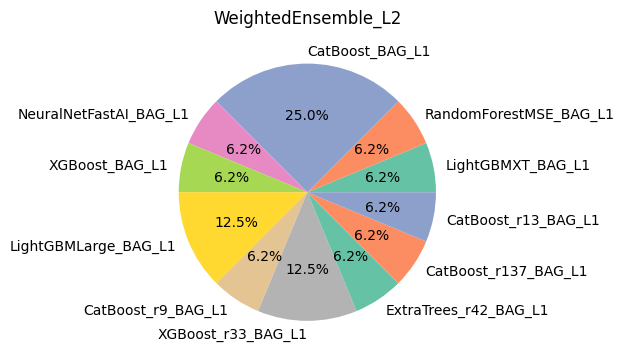

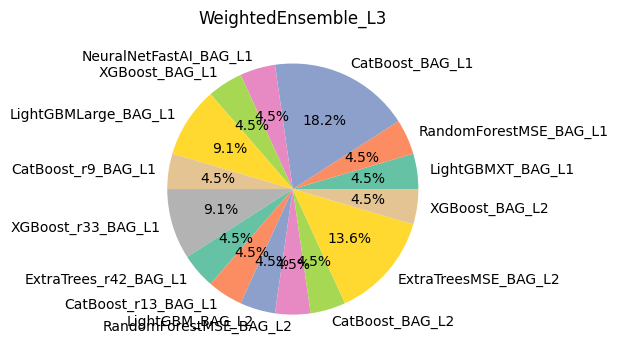

In [10]:
ensemble_weights = get_ensemble_weights(predictor)

for key, value in ensemble_weights.items():
    plt.figure(figsize=(6, 6))
    plt.pie(value.values(), labels=value.keys(), autopct="%1.1f%%", colors=sns.color_palette("Set2", len(value)))
    plt.title(key)
    plt.tight_layout()
    plt.show()

# Collecting and saving OOF files

In [11]:
def save_preds(preds, cv_score, name, type, is_ensemble):
    base_path = "oof_preds" if type == "oof" else "test_preds"
    base_path = "." if is_ensemble else base_path
    joblib.dump(np.expm1(preds), f"{base_path}/{name}_{type}_preds_{cv_score:.6f}.pkl")

def save_submission(test_preds, score):
    sub = pd.read_csv(CFG.sample_sub_path)
    sub[CFG.target] = np.expm1(test_preds)
    sub.to_csv(f"sub_autogluon_{score:.6f}.csv", index=False)
    
os.makedirs("oof_preds", exist_ok=True)
os.makedirs("test_preds", exist_ok=True)

In [12]:
oof_preds = {}
test_preds = {}

In [13]:
best_model = predictor.model_best
_test_preds = predictor.predict_multi(test)
for model in predictor.model_names():
    model_oof_preds = predictor.predict_oof(model).values
    model_test_preds = _test_preds[model].values
    
    cv_score = root_mean_squared_error(train[CFG.target], np.maximum(0, model_oof_preds))
    if model != best_model:
        save_preds(model_oof_preds, cv_score, model, "oof", False)
        save_preds(model_test_preds, cv_score, model, "test", False)
    else:
        save_preds(model_oof_preds, cv_score, model, "oof", True)
        save_preds(model_test_preds, cv_score, model, "test", True)
        save_submission(model_test_preds, cv_score)
        
    oof_preds[model] = model_oof_preds
    test_preds[model] = model_test_preds

# Visualizing the results

In [14]:
scores = {}
split = KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True).split(train, train[CFG.target])
for fold_idx, (train_index, val_index) in enumerate(split):
    for model in predictor.model_names():
        fold_score = root_mean_squared_error(train.loc[val_index, CFG.target], np.maximum(0, oof_preds[model][val_index]))
        if model not in scores:
            scores[model] = []
        scores[model].append(fold_score)

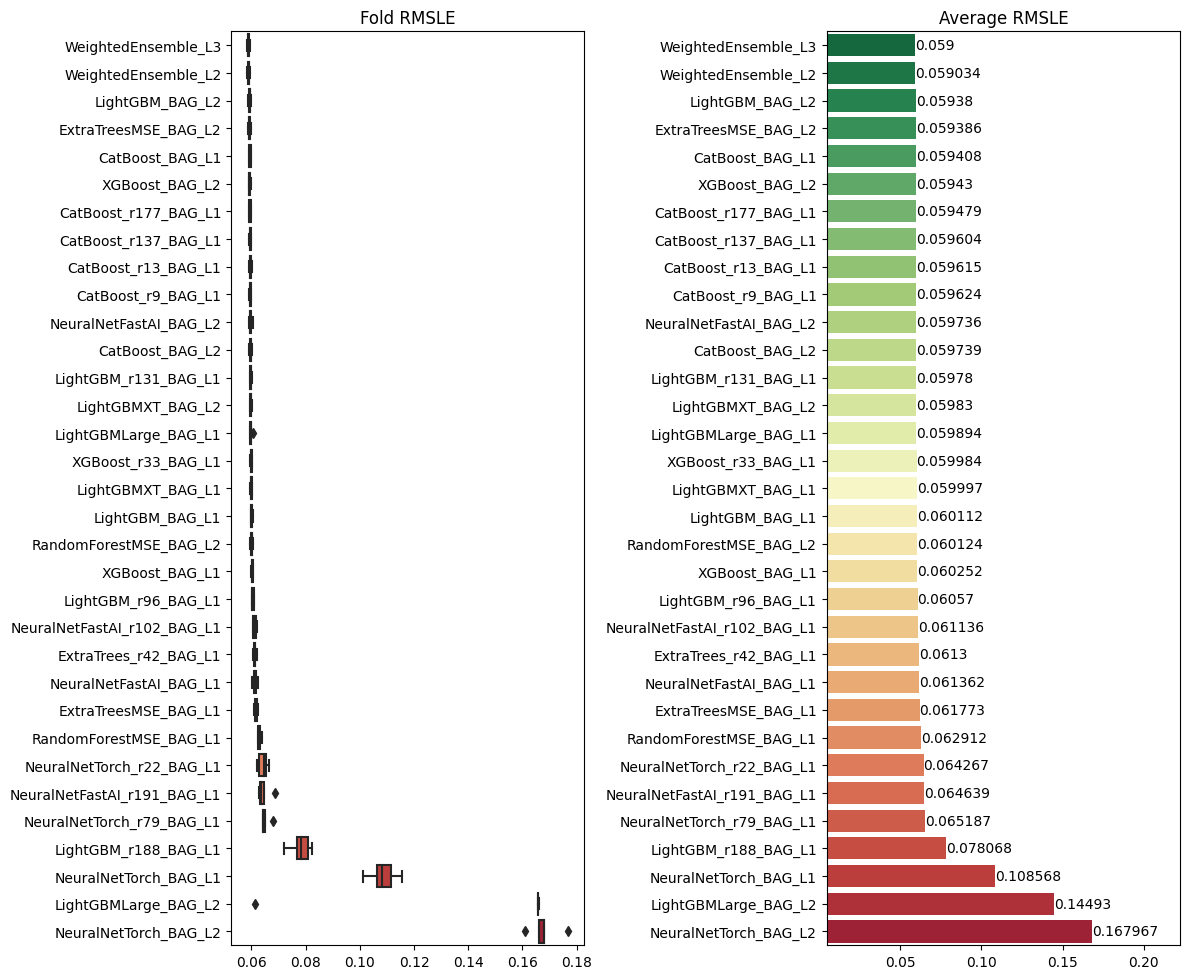

In [15]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=True)
order = scores.mean().sort_values(ascending=True).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(12, scores.shape[1] * 0.3))

sns.boxplot(data=scores, order=order, ax=axs[0], orient="h", palette="RdYlGn_r")
axs[0].set_title("Fold RMSLE")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], palette="RdYlGn_r")
axs[1].set_title("Average RMSLE")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, score in enumerate(mean_scores.values):
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()